#  Уменьшение размерности в задаче классификации лиц
Используя методы уменьшения размерности признаков, решим с максимальным **accuracy** задачу классификации лиц знаменитостей.

Попробуем добиться максимального accuracy
* без уменьшения размерности
* с уменьшением размерности


Загрузка датасета

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)


In [2]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

In [4]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [5]:
y.shape

(2370,)

In [6]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

Реализуем функцию визализации лиц

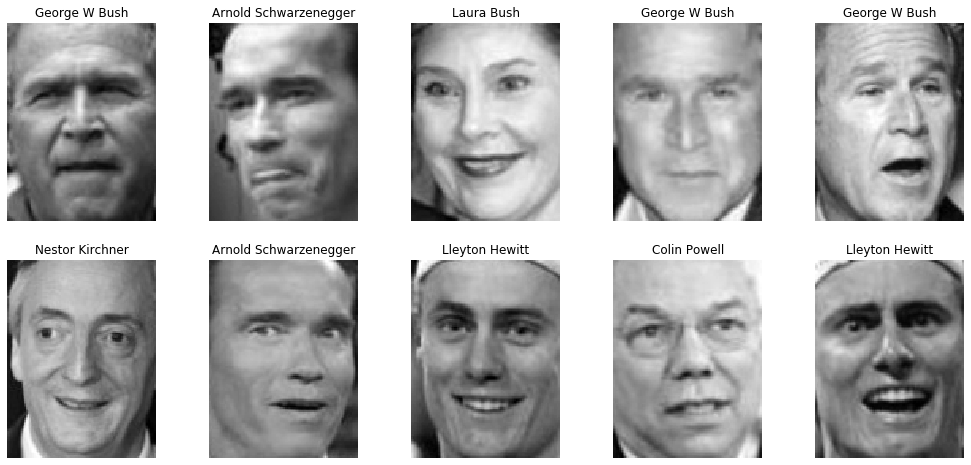

In [48]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

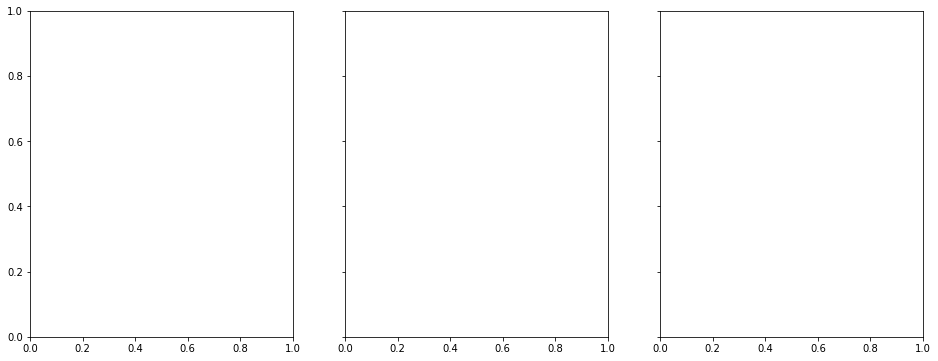

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

img = img_as_float(data.camera())
rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1


def mse(x, y):
    return np.linalg.norm(x - y)

img_noise = img + noise
img_const = img + abs(noise)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6),
                                    sharex=True, sharey=True,
                                    subplot_kw={'adjustable': 'box'})


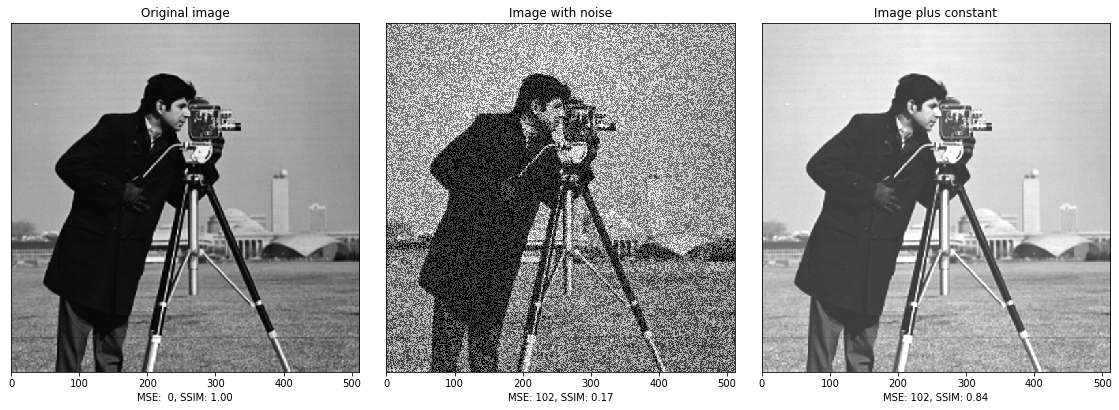

In [51]:


fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6),
                                    sharex=True, sharey=True,
                                    subplot_kw={'adjustable': 'box'})
plt.tight_layout()

mse_none = mse(img, img)
ssim_none = ssim(img, img, dynamic_range=img.max() - img.min())

mse_noise = mse(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  dynamic_range=img_const.max() - img_const.min())

mse_const = mse(img, img_const)
ssim_const = ssim(img, img_const,
                  dynamic_range=img_noise.max() - img_noise.min())

label = 'MSE: %2.f, SSIM: %.2f'

ax0.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax0.set_xlabel(label % (mse_none, ssim_none))
ax0.set_title('Original image')
ax0.axes.get_yaxis().set_visible(False)

ax1.imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax1.set_xlabel(label % (mse_noise, ssim_noise))
ax1.set_title('Image with noise')
ax1.axes.get_yaxis().set_visible(False)

ax2.imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax2.set_xlabel(label % (mse_const, ssim_const))
ax2.set_title('Image plus constant')
ax2.axes.get_yaxis().set_visible(False)

plt.show()

In [13]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

Попробуем добиться максимального accuracy с помощью сингулярного разложения



In [14]:
from sklearn.decomposition import TruncatedSVD

In [23]:
x_ = np.arange(2, 100)
accuracies = []
for i in x_:
  svd = TruncatedSVD(n_components=i)
  X_svd = svd.fit_transform(X)
  l = cross_val_score(LogisticRegression(), X_svd, y, scoring='accuracy').mean()
  accuracies.append(l)

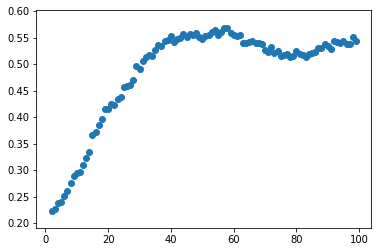

In [25]:
plt.scatter(x_, accuracies)


Видно, что лучше взять количество компонент, равное 35



In [29]:
svd = TruncatedSVD(n_components=35)
X_svd_2 = svd.fit_transform(X)

Собственно, применяем алгоритм линейной регрессии для классификации и считаем accuracy

In [27]:
print('accuracy for data transormed by SVD-35D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_svd_35, y,
                                                                            scoring='accuracy').mean()))

accuracy for data transormed by SVD-35D is 0.5295407970065461


Нарисуем 10 лиц, на которых наш алгоритм ошибся

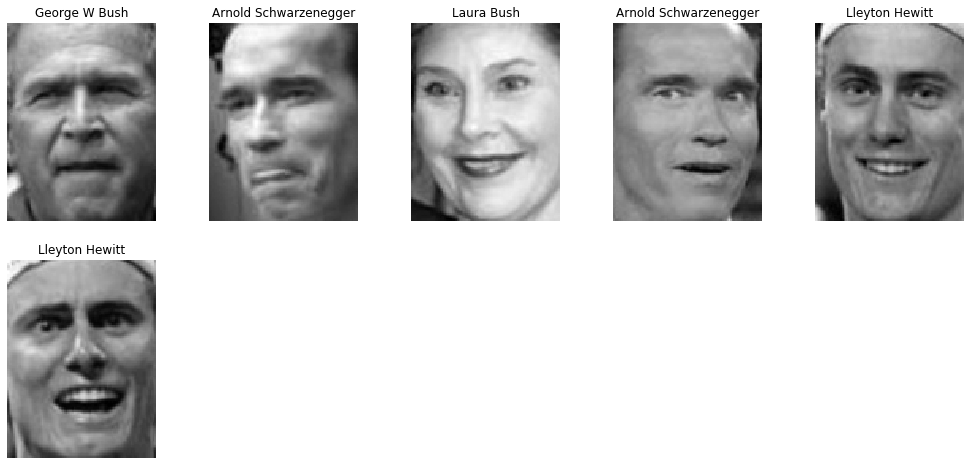

In [33]:
plot_grid(np.arange(10)[errors[:10]], nrows=2, ncols=5)

In [38]:
# Предсказали:
names[y_pred[np.arange(10)[errors[:10]]]]

array(['Tony Blair', 'Tony Blair', 'Colin Powell', 'Colin Powell',
       'Guillermo Coria', 'Gloria Macapagal Arroyo'], dtype='<U25')

In [39]:
# А на самом деле:
names[y[np.arange(10)[errors[:10]]]]

array(['George W Bush', 'Arnold Schwarzenegger', 'Laura Bush',
       'Arnold Schwarzenegger', 'Lleyton Hewitt', 'Lleyton Hewitt'],
      dtype='<U25')

Попробуем добиться максимального accuracy с помощью метода главных компонент








In [40]:
from sklearn.decomposition import PCA

In [54]:
x_ = np.arange(2, 100)
accuracies = []
for i in x_:
  pca = PCA(n_components=i)
  X_pca = pca.fit(X).transform(X)
  l = cross_val_score(LogisticRegression(), X_pca, y, scoring='accuracy').mean()
  accuracies.append(l)

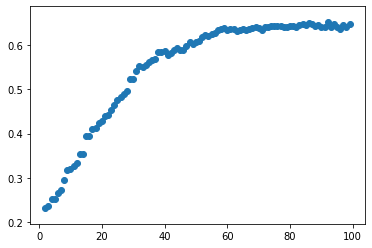

In [43]:
plt.scatter(x_, accuracies)

Видно, что лучше взять количество компонент, равное 40

In [45]:
pca = PCA(n_components=40)
X_pca_40 = pca.fit(X).transform(X)

In [46]:
print('accuracy for data transormed by PCA-40D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_pca_40, y,
                                                                            scoring='accuracy').mean()))

accuracy for data transormed by PCA-40D is 0.5848516770016992


In [47]:
from sklearn.manifold import TSNE


In [0]:
tsne = TSNE(n_components=2, n_iter = 300)

X_tsne_2 = tsne.fit_transform(X)

In [0]:
print('accuracy for data transormed by tSNE-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                             X_tsne_2, y,
                                                                             scoring='accuracy').mean()))

accuracy for data transormed by tSNE-2D is 0.23799821767347354


Посчитаем accuracy для константого предсказания 

Определим самый популярный класс

In [42]:
from collections import Counter
Counter(y)

Counter({8: 530,
         4: 42,
         21: 41,
         25: 37,
         22: 41,
         5: 236,
         7: 121,
         9: 109,
         6: 31,
         13: 71,
         2: 36,
         15: 55,
         17: 53,
         1: 35,
         3: 77,
         26: 30,
         10: 44,
         12: 39,
         16: 42,
         24: 33,
         20: 32,
         31: 144,
         23: 48,
         14: 52,
         28: 52,
         18: 31,
         19: 60,
         30: 33,
         27: 32,
         11: 30,
         33: 49,
         29: 33,
         0: 39,
         32: 32})

In [0]:
y_pred_const = np.ones_like(y) * 8

In [0]:
accuracy_score(y, y_pred_const)

In [0]:
print('accuracy for raw data is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X, y,
                                                                            scoring='accuracy').mean()))

accuracy for raw data is 0.6593131733932284


In [0]:
 print('accuracy for data transormed by const-predict is {}'.format(accuracy_score(y, y_pred_const)))
print('accuracy for data transormed by SVD-35D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_svd_35, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by PCA-40D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_pca_40, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by tSNE-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                             X_tsne_2, y,
                                                                             scoring='accuracy').mean()))

accuracy for data transormed by const-predict is 0.22362869198312235
accuracy for data transormed by SVD-35D is 0.5274929114011015
accuracy for data transormed by PCA-40D is 0.5789284848750411
accuracy for data transormed by tSNE-2D is 0.23799821767347354


In [55]:
# Видно, что при использовании алгоритмов PCA или SVD для уменьшения размерности признакового пространства, можно добиться значительного прогресса по сравнению с константной предсказательной моделью "всегда самый популярный класс"

Посмотрим, несколько изображений, на которых ошибся наш алгоритм

In [0]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [0]:
errors = (y_pred != y_test)
from collections import Counter
Counter(errors)

(474, 11750)


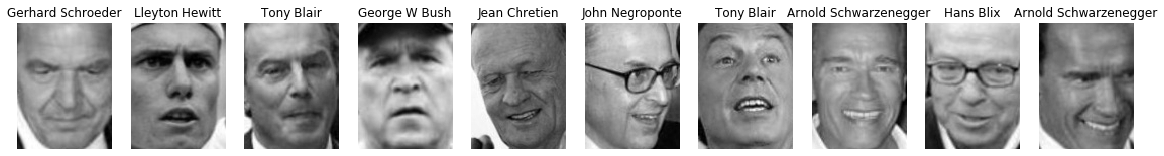

In [0]:
NUMBER_of_PEOPLE = 10

plt.figure(figsize=(20, 12))
print(X_test.shape)
faces = X_test[errors][:NUMBER_of_PEOPLE]
y_reall = y_test[y_pred != y_test][:NUMBER_of_PEOPLE]
y_false_pred = y_pred[y_pred != y_test][:NUMBER_of_PEOPLE]
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i + 1)
    plt.title(names[y_reall[i]])
    plt.axis('off')
    plt.imshow(255 - face.reshape(125, 94), cmap=plt.cm.gray_r, interpolation='nearest')

In [0]:
names[y_reall]

array(['Gerhard Schroeder', 'Lleyton Hewitt', 'Tony Blair',
       'George W Bush', 'Jean Chretien', 'John Negroponte', 'Tony Blair',
       'Arnold Schwarzenegger', 'Hans Blix', 'Arnold Schwarzenegger'],
      dtype='<U25')

In [0]:
names[y_false_pred]

array(['Jacques Chirac', 'Guillermo Coria', 'Donald Rumsfeld',
       'Guillermo Coria', 'Alvaro Uribe', 'Donald Rumsfeld',
       'Jacques Chirac', 'Tony Blair', 'Donald Rumsfeld', 'Andre Agassi'],
      dtype='<U25')

Визуализируем наш датасет (преобразованный PCA/TSNE) на плоскости






In [0]:
Counter(y)

In [0]:
pca = PCA(n_components=2)
X_pca_2 = pca.fit(X).transform(X)

In [0]:
from matplotlib.colors import Normalize


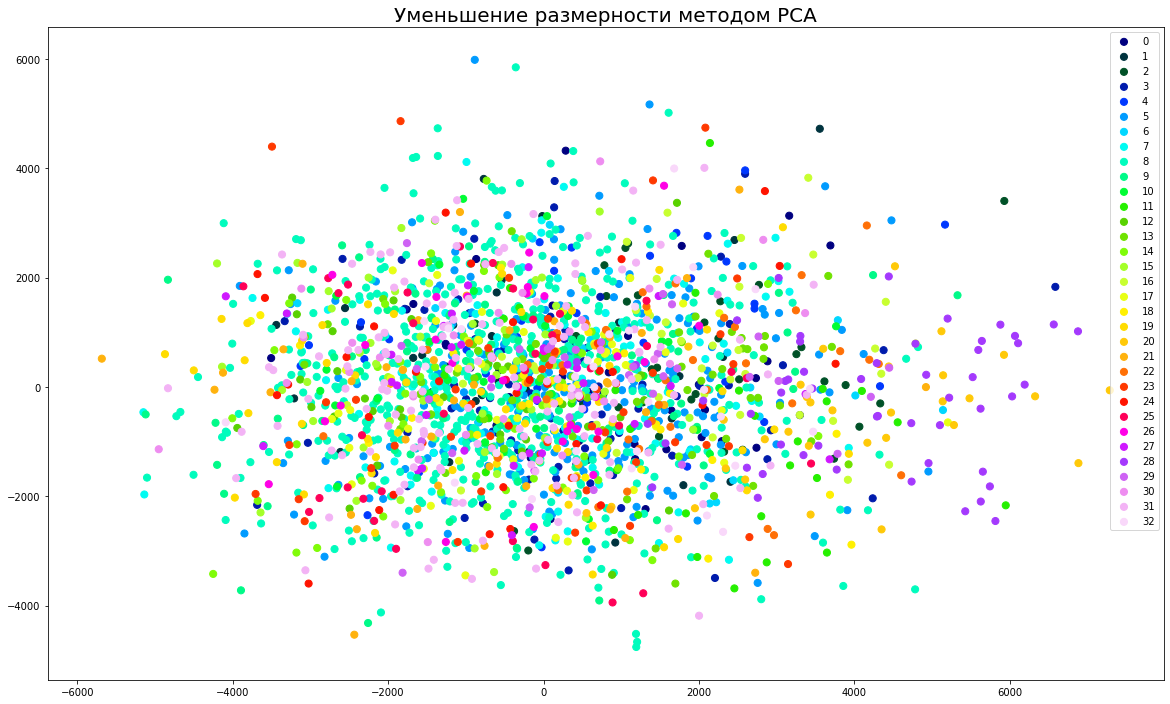

In [17]:
plt.figure(figsize=(20, 12))
for d in range(33): # перебираем цифру
    norm = Normalize(vmin=0, vmax=33) # для красивых цветов
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_pca_2[:, 0][y == d],
                X_pca_2[:, 1][y == d],
                c=[color] * len(X_pca_2[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом PCA", fontsize=20)
plt.legend()

In [0]:
tsne = TSNE(n_components=2, n_iter = 300)

X_tsne_2 = tsne.fit_transform(X)

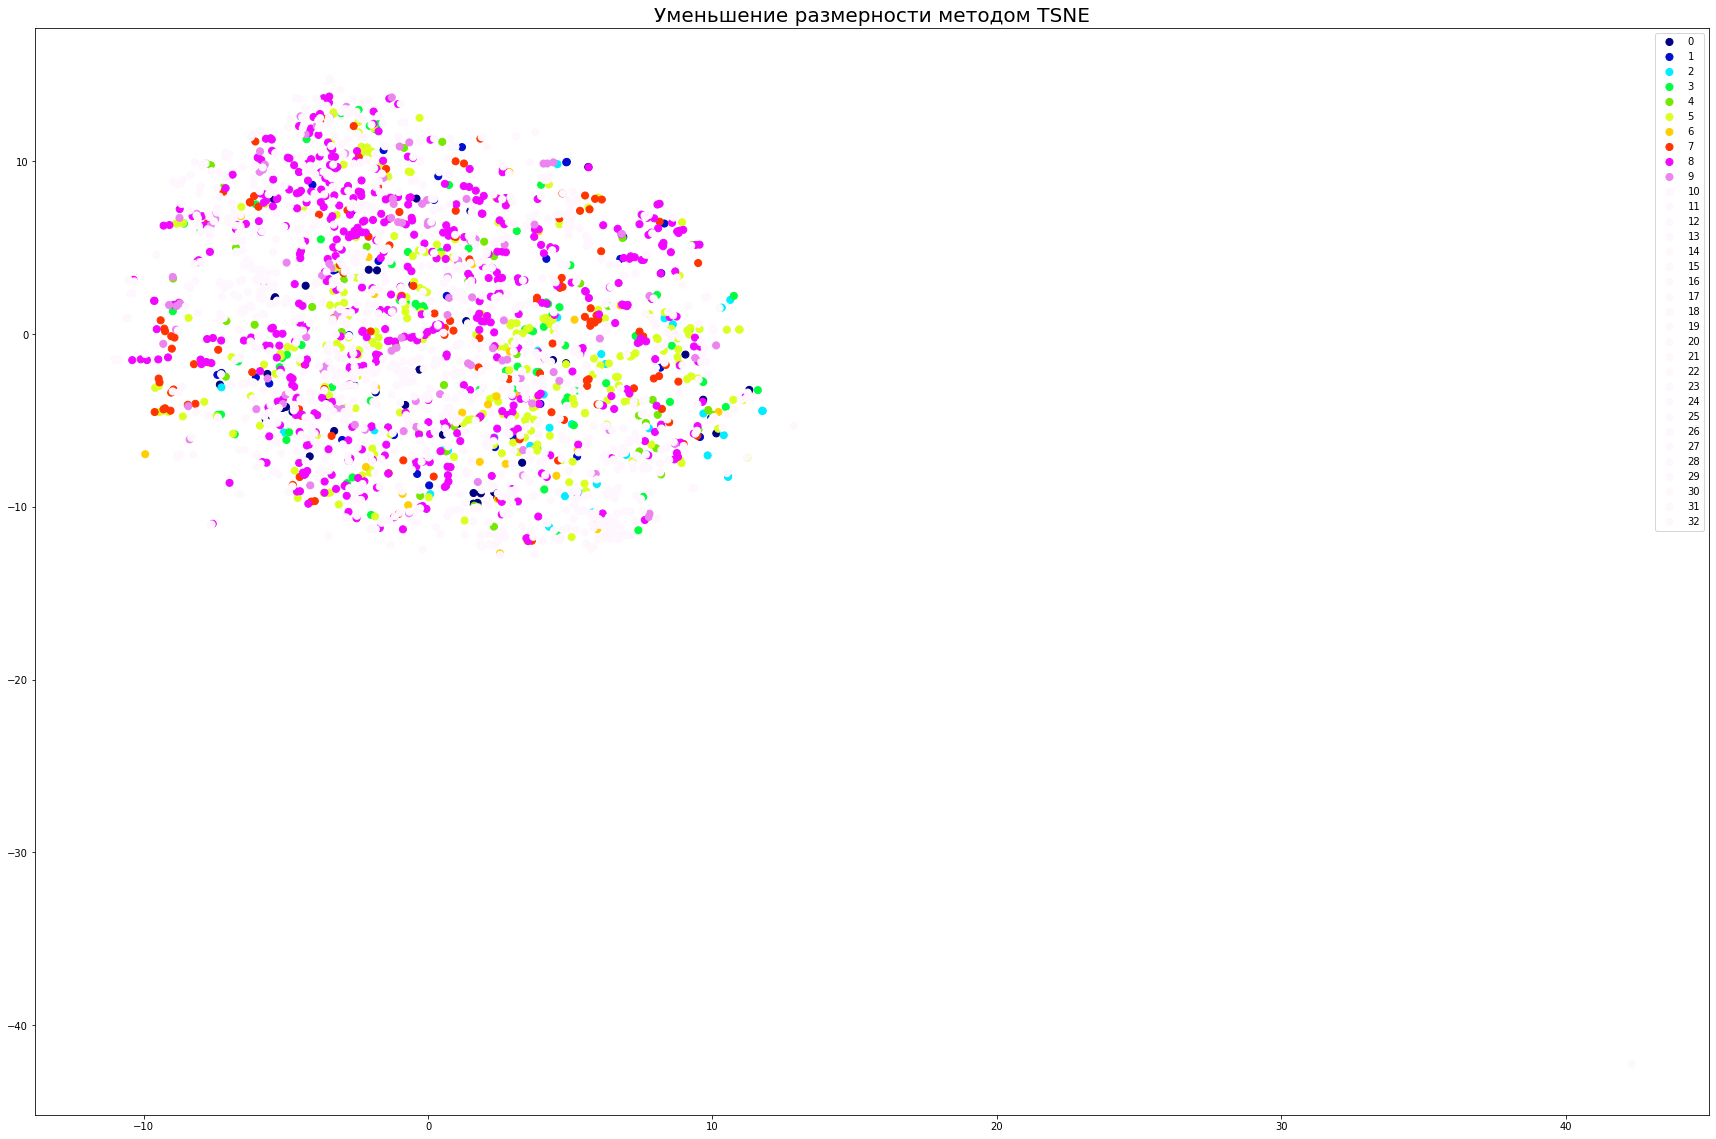

In [20]:
from matplotlib.colors import Normalize
plt.figure(figsize=(30  , 20))
for d in range(33): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_tsne_2[:, 0][y == d],
                X_tsne_2[:, 1][y == d],
                c=[color] * len(X_tsne_2[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом TSNE", fontsize=20)
plt.legend()

Просто ради интереса посмотрим, какой результат выдает дерево решений

In [0]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier()


In [0]:
clf = DecisionTreeClassifier(max_depth=50, random_state=42,)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.31013


In [0]:
NUMBER = 10
for i in range(NUMBER):
    
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
